<h1 align=center>BANKRUPTCY IN TAIWAN COMPANIES</h1>
<h4 align=center> By Muhammad Jamil Abdulhamid </h4>

<img src="bankruptcy.jpg" alt="image_caption" >
<h4 align-left>Image by <a href="https://pixabay.com/users/geralt-9301/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=96612">Gerd Altmann</a> from <a href="https://pixabay.com//?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=96612">Pixabay</a>

## Table of Contents
<ul>
<li><a href="#intro"> 1. Introduction</a></li>
<li><a href="#eda">2. Exploratory Data Analysis</a></li>
<li><a href="#model">3. Model Selection and Evaluation</a></li>
<li><a href="#conclusions">4. Conclusions</a></li>
<li><a href="#ref">5. References</a></li>
</ul>

<div id='intro'></div>

## 1. Introduction

During financial turmoil, companies all over the world battle with the threat of either going bankrupt or otherwise. In this project, bankruptcy data of companies in Taiwan will be used to build a model to predict whether a company will go bankrupt or not. Models like this will help prevent bankruptcy in future financial crisis, thereby saving shareholders investment and the economy as a whole.


### 1.1 About the data

The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange. The data can be downloaded ([here](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction)).

### 1.2 Importing libraries

The following libraries will be imported.

In [1]:
import numpy as np
import pandas as pd
from zipfile import ZipFile
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix
)

### 1.3 Load datasets

In [2]:
# Extract csv file from the zip file
filename = "Taiwan.zip"
with ZipFile(filename, "r") as f: 
    # printing content of zip file
    f.printdir()
    # Extracting
    print("Extracting all the files....")
    f.extractall()
    print("Done.")

File Name                                             Modified             Size
data.csv                                       2021-02-13 19:36:06     11456101
Extracting all the files....
Done.


In [3]:
# Create dataframe
Taiwan_df = pd.read_csv('data.csv')
# Preview dataframe
print("Shape of Taiwan_df:", Taiwan_df.shape)
Taiwan_df.head()

Shape of Taiwan_df: (6819, 96)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


### 1.4 Check for any missing Values

In [4]:
# Is there a missing data in the datasets?
nans_by_col = pd.Series(Taiwan_df.isna().sum())
print("nans_by_col shape:", nans_by_col.shape)
nans_by_col.head(5)

nans_by_col shape: (96,)


Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
dtype: int64

<div id='eda'></div>

## 2. Exploratory Data Analysis

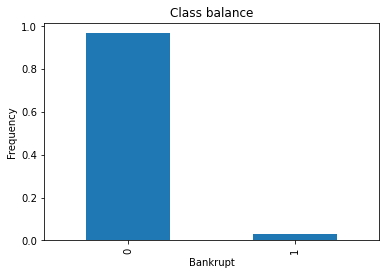

In [4]:
# Plot class balance
Taiwan_df["Bankrupt?"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Bankrupt",
    ylabel="Frequency",
    title='Class balance'
);

<div id='model'></div>

## 3. Model Selection and Evaluation

In this section, we will split our data into target vector and feature matrix. We will then build our model and evaluate it.

### 3.1 Split Data

In [5]:
# Set "Bankrupt?"column as target
target = "Bankrupt?"
# Create target vector and features matrix
X = Taiwan_df.drop(columns=target)
y = Taiwan_df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6819, 95)
y shape: (6819,)


### 3.2 Divide data into train and test sets

In [6]:
# Divide data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5455, 95)
y_train shape: (5455,)
X_test shape: (1364, 95)
y_test shape: (1364,)


### 3.3 Build random forest model with hyperparameters

In [7]:
# Number of trees in random forest 
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every  split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2, 4]
# Minimum number of samples required to split a split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [8]:
# Create param grid
param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
    
}

print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [9]:
# Create a classifier

clf = RandomForestClassifier(random_state=42)

In [10]:
# Perform cross-validation with your classifier using the over-sampled training data, and assign your results to cv_scores.

cv_scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print(cv_scores)

[0.96975252 0.9715857  0.97433547 0.97341888 0.97250229]


In [11]:
# Create a GridSearchCV named model that includes your classifier and hyperparameter grid.

model = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [12]:
# Fit the model

model.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


C:\Users\USER\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=1)

In [13]:
# model score on test data
model.score(X_test, y_test)

0.9655425219941349

### 3.4 Extract best param and estimator from model

In [14]:
best_param = model.best_params_
best_param

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 56}

In [15]:
final_clf = model.best_estimator_
final_clf

RandomForestClassifier(max_depth=4, max_features='auto', min_samples_leaf=2,
                       n_estimators=56, random_state=42)

### 3.5 Check accuracy

In [16]:
acc_train = final_clf.score(X_train, y_train)
acc_test = final_clf.score(X_test, y_test)

print("Train Accuracy: ", round(acc_train, 4))
print("Test Accuracy: ", round(acc_test, 4))

Train Accuracy:  0.9754
Test Accuracy:  0.9655


In [17]:
# Extract cross-validation results

cv_results = pd.DataFrame(model.cv_results_)
cv_results.sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
146,1.279467,0.050461,0.031182,0.009234,True,4,sqrt,2,2,56,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",0.968836,0.970669,0.971586,0.970669,0.971586,0.970669,0.001004,1
106,1.197914,0.026635,0.028784,0.002480,True,4,auto,2,2,56,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",0.968836,0.970669,0.971586,0.970669,0.971586,0.970669,0.001004,1
142,0.487920,0.011172,0.015192,0.001720,True,4,sqrt,2,2,25,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",0.967003,0.970669,0.971586,0.970669,0.972502,0.970486,0.001869,3
157,1.276468,0.006271,0.024987,0.000631,True,4,sqrt,2,5,64,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",0.968836,0.971586,0.969753,0.971586,0.970669,0.970486,0.001069,3
123,0.640832,0.016158,0.016391,0.001854,True,4,sqrt,1,2,33,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",0.967003,0.970669,0.971586,0.969753,0.973419,0.970486,0.002122,3


### 3.6 Evaluate

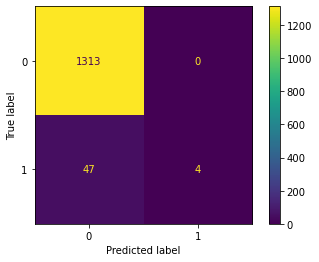

In [18]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

In [19]:
class_report = classification_report(y_test, model.predict(X_test))
print(class_report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1313
           1       1.00      0.08      0.15        51

    accuracy                           0.97      1364
   macro avg       0.98      0.54      0.56      1364
weighted avg       0.97      0.97      0.95      1364



### 3.7 Communicate

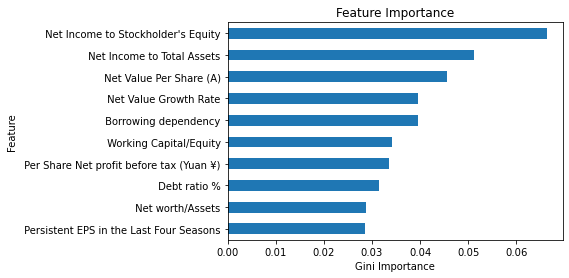

In [20]:
# Get feature names from training data
features = X_train.columns
# Extract importances from model
importances = final_clf.feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [21]:
# Save model
with open("model-twn-bankruptcy.pkl", 'wb') as f:
    pickle.dump(final_clf,f)

<div id='conclusions'></div>

## 4. Conclusions

Based on the evaluation result of our model, we were able to predict bankruptcy with high level of accuracy. The top 10 most importing features leaading to bankruptcy were also extracted. Model like this can preven huge economic losses during financial crisis.

<div id='ref'></div>

## 5. References

1. https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction
2. https://scikit-learn.org/stable/